<h1>Homework 3 - Grégoire Boussac</h1>

In [1]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys

np.random.seed(0) # For the reproducibility of the experiments

- Objectives functions

In [2]:
# Dual objective
f0 = lambda v, Q, p : (np.dot(np.transpose(v),np.dot(Q, v))
                    + np.dot(np.transpose(p), v))

# Constraints
fi = lambda v, A, lmbd, i : np.dot(np.transpose(A[i]), v) - lmbd

# Log-barriere of the constraints
phi = lambda v, A, lmbd : -np.sum(np.log(-fi(v, A, lmbd, i))
                            for i in range(len(v)))

# Lagragian of the dual with log-barriere
f = lambda v, A, p, Q, lmbd, t : t*f0(v, Q, p) + phi(v, A, lmbd)

- Useful to get the i-th column of a numpy array

In [3]:
def get_column(X, i):
    return np.vstack(X[:, i])

- Functions to compute the gradient and the hessian of the (QP) with log-barrier penalty.

In [4]:
def compute_grad_f(v, p, A, Q, lmbd, t):
    
    return (t*np.dot(Q + np.transpose(Q), v) + t*p
            - np.sum(A[i].reshape(n, 1)/fi(v, A, lmbd, i) for i in range(len(v))))
    # No need to put * Identity thanks to numpy's properties

In [5]:
def compute_hess_f(v, A, Q, lmbd, t):
    
    coeff_hess_phi = (np.sum(np.linalg.norm(A[i])**2/(fi(v, A, lmbd, i)**2) for i in range(len(v)))
                    - np.sum(1/(fi(v, A, lmbd, i)) for i in range(len(v))))
    
    return (t*(Q+np.transpose(Q)) + coeff_hess_phi) # No need to put * Identity thanks to numpy's properties

- Functions to compute the Newton step and the decrement

In [6]:
def compute_newton_step(grad_f, hess_f):
    
    newton_step = - np.dot(np.linalg.inv(hess_f), grad_f)
    
    return newton_step

In [7]:
def compute_decrement(grad_f, hess_f):
    
    decrement = np.dot(np.transpose(grad_f), np.dot(np.linalg.inv(hess_f), grad_f))
    
    return decrement

- Backtrakcing line search

In [8]:
def backtracking_line_search(alpha, beta, f, grad_f, v, newton_step, *params):
    
    h = 1
    while (f(v + h*newton_step, *params) >= f(v, *params) + alpha * h * np.dot(np.transpose(grad_f), newton_step)).any():        
        h *= beta
    
    return h

- Requested functions

In [9]:
def centering_step(Q, p, A, b, t, v0, eps):

    v_seq = v0 # This matrix will contain the different v_t encountered
    v = v0 # Initial state

    while True:
        
        # Compute the hessian and the gradient
        grad_f = compute_grad_f(v, p, A, Q, lmbd, t)
        hess_f = compute_hess_f(v, A, Q, lmbd, t)
        
        # Check any error that would appear with the hessian
        if np.sum(hess_f < 0):
            print('Erreur Hess')
        
        # Compute the decrement and the Newton step
        decrement = compute_decrement(grad_f, hess_f)
        newton_step = compute_newton_step(grad_f, hess_f)
        
        # Stopping criterion
        if decrement / 2 <= eps:
            break
            
        # Backtracking line search
        h = backtracking_line_search(alpha, beta, f, grad_f, v, newton_step,
                                        A, p, Q, lmbd, t)
        
        # Update the state
        v += h*newton_step
        
        # Memorize current state
        v_seq = np.concatenate((v_seq, v), axis=1)
    
    return v_seq

In [10]:
def barr_method(Q, p, A, b, v0, eps, mu):
    
    v_seq = v0 # This matrix will contain the different v_t encountered
    v = v0 # Initial state
    
    t = 1 # Initial parameter t_0
    
    while True:
        # Centering step
        v_seq_center = centering_step(Q, p, A, b, t, v, eps)
        # Retrieve last colum of v_seq_center
        v_star = get_column(v_seq_center, -1)
        
        # Ignore path for the first centering step
        if t==1: # First centering step
            v_seq = np.concatenate((v_seq, v_star), axis=1)
        else:
            v_seq = np.concatenate((v_seq, v_seq_center), axis=1)
        
        # Update the state
        v = v_star
        
        # Stopping criterion
        if 2*d/t < eps:
            break
        
        # Update the parameter
        t *= mu

    return v_seq

<h2>Experiments</h2>

- Set the frame of the experiments :

In [11]:
# Parameters of the experiments
n = 50
d = 100
lmbd = 10
eps = 1e-3
alpha = 0.1
beta = 0.1

# Generate random data
X = np.random.rand(n, d)
y = np.random.rand(n, 1)

# Create the variables for the LASSO problem
A = np.concatenate([np.transpose(X), -np.transpose(X)])
b = lmbd * np.ones((2*d, 1))
Q = 1/2 * np.identity(n)
p = y

# Set initial state
v0 = (1/n) * np.ones((n,1)) # v0 is always a feasible solution, by construction of X and y

In [12]:
# Check if tXX is invertible
if np.linalg.det(np.dot(np.transpose(X), X))==0:
    print("The matrix tXX is not invertible. It is not suprising because d>>n.")

The matrix tXX is not invertible. It is not suprising because d>>n.


- Plot the evolution of the gap, for diffent values of $\mu$ :

>> Computing solution for mu=1.1
>> Computing solution for mu=1.5
>> Computing solution for mu=2
>> Computing solution for mu=15
>> Computing solution for mu=50
>> Computing solution for mu=100
>> Computing solution for mu=300


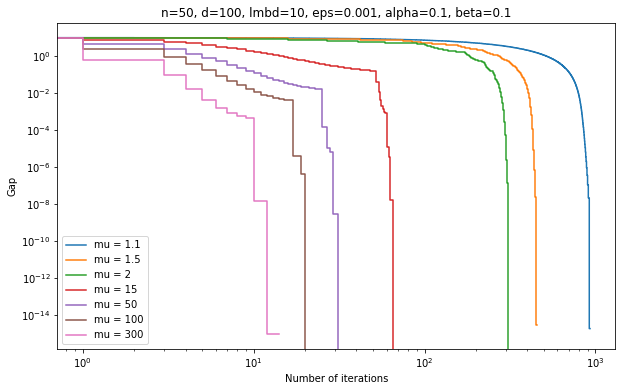

In [13]:
plt.figure(figsize=(10, 6))

for mu in [1.1, 1.5, 2, 15, 50, 100, 300]:
    
    print('>> Computing solution for mu={}'.format(mu))
    
    # Apply the barrier method 
    v_seq = barr_method(Q, p, A, b, v0, eps, mu)
    # Get best value found for v_t
    v_star = get_column(v_seq, -1)
    # Compute the surrogate of the optimal value
    f_star = f0(v_star, Q, p)[0][0]

    # Compute the evolution of the gap
    gap_evolution = [f0(get_column(v_seq, i), Q, p)[0][0] - f_star for i in range(v_seq.shape[1])]
    
    # Plot this evolution for the given value of mu
    plt.step(range(v_seq.shape[1]), gap_evolution, label='mu = {}'.format(mu))
    
# Display the graph    
plt.xlabel("Number of iterations")
plt.ylabel("Gap")
plt.yscale('log')
plt.xscale('log')
plt.title('n=50, d=100, lmbd=10, eps=0.001, alpha=0.1, beta=0.1')
plt.legend()
plt.show()

- Plot the number of iterations when mu increases

100%|██████████| 498/498 [03:13<00:00,  2.58it/s]


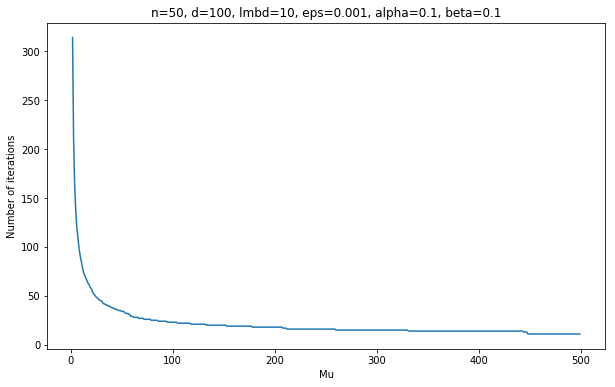

In [17]:
number_iterations = []
norm_inf = []
norm_2 = []

for mu in tqdm(range(2, 500)):
    
    # Apply the barrier method 
    v_seq = barr_method(Q, p, A, b, v0, eps, mu)
    # Get best value found for v_t
    v_star = get_column(v_seq, -1)
    # Compute the surrogate of the optimal value
    f_star = f0(v_star, Q, p)[0][0]

    # Store the total number of iterations
    number_iterations.append(v_seq.shape[1])
    
    # Compute w_star_approx and its norm_/norm_inf
    w_star_approx = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T , np.sqrt(2)*v_star + y))
    norm_inf.append(max(abs(w_star_approx))[0])
    norm_2.append(np.linalg.norm(w_star_approx, ord=2))

# Display the graph    
plt.figure(figsize=(10, 6))
plt.plot(range(2, 500), number_iterations)
plt.xlabel("Mu")
plt.ylabel("Number of iterations")
plt.title('n=50, d=100, lmbd=10, eps=0.001, alpha=0.1, beta=0.1')
plt.show()

- Study the impact of $\mu$ on $w$ :

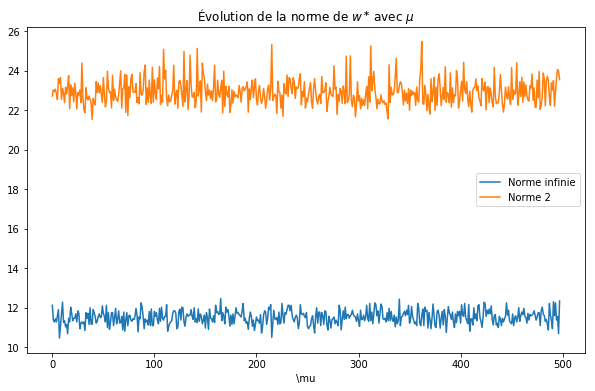

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(norm_inf, label='Norme infinie')
plt.plot(norm_2, label='Norme 2')
plt.xlabel(r'\mu')
plt.legend()
plt.title(r'Évolution de la norme de $w^{\ast}$ avec $\mu$')
plt.show()